In [1]:
from stravalib.client import Client
import time
import pandas as pd
import matplotlib.pyplot as plt
from darksky import forecast
from pygam import LinearGAM, s, f

import numpy as np
from datetime import datetime as dt
import datetime
%matplotlib inline


def dist_conversion(values,from_unit='meters',to_unit='meters'):
    values_copy = values.copy()
    if from_unit == 'meters':
        pass
    elif from_unit == 'feet':
        values_copy /= 3.281
    elif from_unit == 'miles':
        values_copy *= 1609.344
    elif from_unit == 'km':
        values_copy /= 1000
    else:
        raise ValueError("enter a valid input distance unit: meters, feet, miles, km")
        
    if to_unit == 'meters':
        pass
    elif to_unit == 'feet':
        values_copy *= 3.281
    elif to_unit == 'miles':
        values_copy /= 1609.344
    elif to_unit == 'km':
        values_copy /= 1000
    else:
        raise ValueError("enter a valid output distance unit: meters, feet, miles, km")
    
    return values_copy
        
def speed_conversion(values, from_unit='mps',to_unit='mps'):
    values_copy = values.copy()
    if from_unit == 'mps':
        pass
    elif from_unit == 'mpm':
        values_copy = 1609.344/(values_copy*60.0)
    elif from_unit == 'mph':
        values_copy /=2.23694
    else:
        raise ValueError("enter a valid input distance unit: mps, mph, mpm")
        
    if to_unit == 'mps':
        pass
    elif to_unit == 'mpm':
        values_copy = 1609.344/(values_copy*60.0)
    elif to_unit == 'mph':
        values_copy *= 2.23694
    else:
        raise ValueError("enter a valid input distance unit: mps, mph, mpm")
    
    return values_copy

def get_gear_name(df):
    gear_ids = df.gear_id.unique()
    gear_ids = gear_ids[gear_ids != None]
    gear_names = [client.get_gear(g).name for g in gear_ids]
    df['gear']=df['gear_id'].replace(gear_ids,gear_names)
    return df



client_id=34425
client_secret=''#commented out for github
darksky_key=''#commented out for github
refresh_token=''#commented out for github
client=Client()

token = client.refresh_access_token(client_id=client_id, client_secret=client_secret,
        refresh_token=refresh_token)




In [2]:
#request all strava activities through the strava API
start = time.time()
activities=list(client.get_activities())
end = time.time()
print(end - start)

8.40042781829834


In [3]:
#define variable lists

raw=['name','distance','moving_time','elapsed_time','total_elevation_gain',\
          'elev_high','type','start_date_local','start_latitude','start_longitude',\
          'kudos_count','average_speed','max_speed','gear_id']#'average_heartrate','max_heartrate',

weather_fields = ['apparentTemperature']#,'temperature','humidity','windSpeed']

In [4]:
#create dataset

start = time.time()

metric = False
df = pd.DataFrame({r:[activities[i].to_dict().get(r) for i in range(len(activities))] for r in raw})
df['start_date_local_dt'] = pd.to_datetime(df.start_date_local)
df['moving_time'] = pd.to_timedelta(df.moving_time).dt.total_seconds()
df['elapsed_time'] = pd.to_timedelta(df.elapsed_time).dt.total_seconds()
if not metric:
    df['miles'] = dist_conversion(df['distance'],from_unit='meters',to_unit='miles')
    df['pace'] = speed_conversion(df['average_speed'],from_unit='mps',to_unit='mpm')
    df['elev_high'] = dist_conversion(df['elev_high'],to_unit='feet')
    df['mph'] = speed_conversion(df['average_speed'],to_unit='mph')
    df['grade'] = (df['total_elevation_gain']*100)/df['distance']
    df['elevation_feet'] = dist_conversion(df['total_elevation_gain'],from_unit='meters',to_unit='feet')
    df['date']= (df['start_date_local_dt'] - datetime.datetime(1970,1,1)).dt.total_seconds()
    df['hour']= df['start_date_local_dt'].dt.hour

##adding gear names
df = get_gear_name(df)

#dropping activities without GPS data and walks mislabled as runs
df=df[(df['type']=='Run')&(~df['start_longitude'].isnull())&(df['pace']<15)].reset_index()


#adding temperature data
df[weather_fields[0]]={w:[forecast(darksky_key,
         df.loc[i,'start_latitude'],
         df.loc[i,'start_longitude'],
         df.loc[i,'start_date_local']).hourly[df.loc[i,'start_date_local_dt'].hour].__dict__['_data'].get(w)
    for i in range(len(df))] for w in weather_fields}[weather_fields[0]]


end = time.time()
print(end - start)

activity_types = df['type'].unique()

62.81351161003113


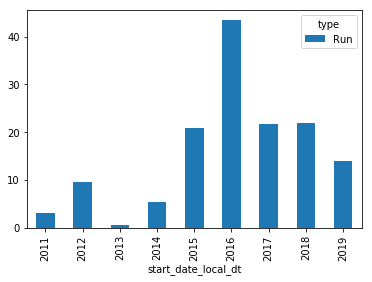

In [5]:
#stacked bar plot of activity hours by year

dimensions = {'distance':'sum',
              'moving_time':'sum',
              'total_elevation_gain':'sum',
             'max_speed':'max',
             'average_speed':'mean'}

groups = [df.type,df.start_date_local_dt.dt.year]

grouped = df.groupby(by=groups).agg(dimensions).unstack(fill_value=0)
(grouped.T.xs('moving_time')/3600).plot(kind='bar',stacked=True)

In [6]:
#setup GAM dataset

GAM_target = ['pace']
GAM_features = ['elev_high','miles','date','apparentTemperature','grade','hour']

GAM_df = df.loc[df['type']=='Run',GAM_target+GAM_features].dropna()
X = GAM_df[GAM_features]
y = GAM_df['pace']

In [7]:
#fit GAM

from pygam import LinearGAM, s, f,PoissonGAM,InvGaussGAM
lams = np.logspace(-2, 2, 3)
lams = [lams] * len(GAM_features)

gam =  LinearGAM().fit(X,y).gridsearch(X, y, lam=lams)

100% (729 of 729) |######################| Elapsed Time: 0:00:31 Time:  0:00:31


/opt/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  after removing the cwd from sys.path.


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     25.1556
Link Function:                     IdentityLink Log Likelihood:                                  -332.2027
Number of Samples:                          285 AIC:                                              716.7166
                                                AICc:                                             722.2259
                                                GCV:                                                0.7054
                                                Scale:                                              0.5943
                                                Pseudo R-Squared:                                    0.311
Feature Function                  Lam

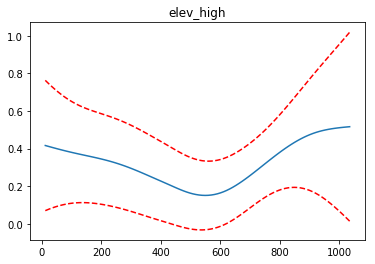

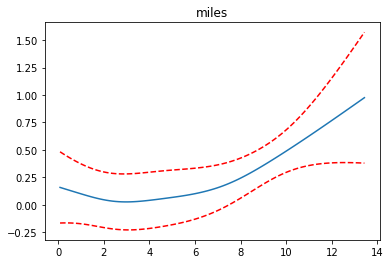

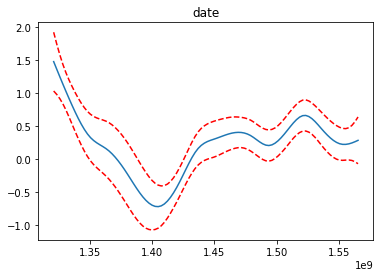

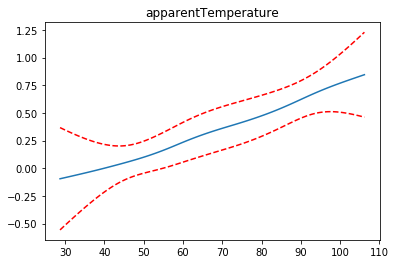

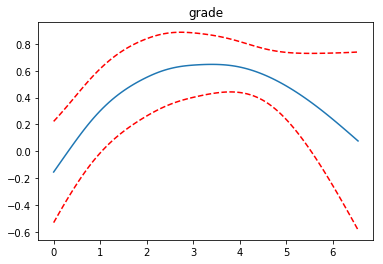

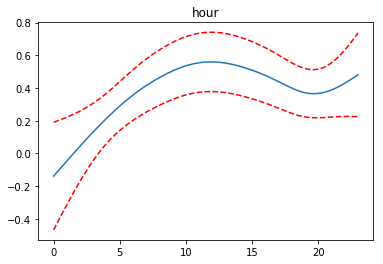

In [8]:

#plot out GAM summary
#need to do some model selection here

gam.summary()
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.90)
    plt.figure()
    plt.plot(XX[:, term.feature], (pdep))#+gam.coef_[-1]))
    plt.plot(XX[:, term.feature], (confi), c='r', ls='--')#+gam.coef_[-1]
    plt.title(X.columns[term.feature])
    plt.show()


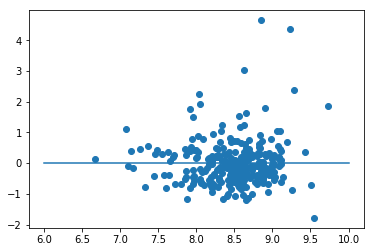

In [9]:
#residual plot
plt.plot([6,10],[0,0])
plt.scatter(gam.predict(X),y-gam.predict(X))